In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt

In [2]:
from pyvista import examples
import pyvista as pv

mesh = examples.download_st_helens()
warped = mesh.warp_by_scalar('Elevation')

In [5]:
#pl = pv.PlotterITK()
#pl.add_mesh(warped)
#pl.show(True)
x=1

In [106]:
from scipy import ndimage as ndi
from skimage.morphology import (square, rectangle, diamond, disk, cube,
                                octahedron, ball, octagon, star)

image = np.array(disk(2),dtype=np.bool)
image = np.pad(image,pad_width=[(10,6),(10,8)],constant_values=0.0)
image = np.invert(image).astype(np.float)

In [60]:
from skimage import data
from skimage.util import invert
from skimage.morphology import skeletonize

blobs = data.binary_blobs(1000, blob_size_fraction=.1,
                          volume_fraction=.25, seed=1)

image = skeletonize(blobs, method='lee').astype(float)
image[image>0]=10
image[image==0]=1.0
image[image==10]=0.1

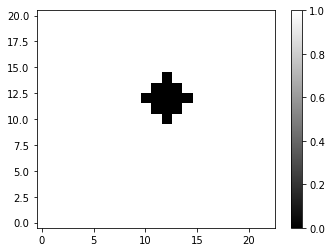

In [107]:
plt.imshow(image,cmap=plt.cm.gray,origin="lower")
plt.colorbar()
plt.show()

In [95]:
from numba import jit

@jit(nopython=True)
def getI_J_K(ijk,shape):
    #Find index [i,j,k] from a flat 3D matrix index [i,j,k]
    NX,NY,NZ = shape
    i,j,k=0,0,0
    
    #Col major
    #i=ijk%NX
    #j=((int)(ijk / NX)) % NY
    #k=(int)(ijk / (NX*NY))

    #Row major
    k = ijk%NZ
    j = ((int)(ijk / NZ)) % NY
    i = (int)(ijk / (NZ*NY))
    
    return i,j,k

@jit(nopython=True)
def getIJK(i,j,k,shape):
    #Convert index [i,j,k] to a flat 3D matrix index [ijk]
    NX,NY,NZ = shape
    
    #Col major
    #return i + (NX)*(j + k*(NY))

    #Row major
    return k + NZ*(j+i*NY)

@jit(nopython=True)
def fastHJ(ffun, dims, dx, hgradation, imax=10000, aset0=None):
    ftol = np.min(ffun)*np.sqrt(1e-9)

    dfdx = hgradation-1.0
    elen = dx
    
    npos = np.zeros(7,dtype=np.int32)
    
    #output field, convert into 1d for generic nD indexing
    ffun_s = np.empty_like(ffun.size,dtype=np.float64)
    ffun_s = ffun.flatten()
    
    #we only search the cell near the sharp region which masked by aset
    if(aset0 is not None):
        aset = aset0
    else:
        aset = np.zeros_like(ffun_s,dtype=np.int32)

    #print('Iteration #Active cell')
    for it in range(1,imax+1):
        aidx = np.where(aset==it-1)[0] #Find gradient sharp region
        
        #print(it,'\t',len(aidx) )
        if(len(aidx)==0): break
        
        for idx in range(len(aidx)):#Check gradient and change size function
            IJK = aidx[idx]
            
            I,J,K = getI_J_K(IJK, dims)
            
            #Gather indices using 4 (6 in 3d) edge stencil centered on inod
            npos[0] = IJK

            npos[1] = getIJK(min(I+1,dims[0]-1), J, K, dims)
            npos[2] = getIJK(max(I-1,0), J, K, dims)

            npos[3] = getIJK(I, min(J+1, dims[1]-1), K, dims)
            npos[4] = getIJK(I, max(J-1,0), K, dims)

            npos[5] = getIJK(I, J, min(K+1,dims[2]-1), dims)
            npos[6] = getIJK(I, J, max(K-1,0), dims)

            
            #----------------- calc. limits about min.-value
            nod1 = npos[0]
            for p in range(1,7):
                nod2 = npos[p]
                #if(nod1==nod2): continue                
                #print(p,nod1,nod2)
                if (ffun_s[nod1] > ffun_s[nod2]):
                    fun1 = ffun_s[nod2] + elen * dfdx
                    if (ffun_s[nod1] > fun1 + ftol):
                        ffun_s[nod1] = fun1
                        aset[nod1] = it
                else:
                    fun2 = ffun_s[nod1] + elen * dfdx
                    if (ffun_s[nod2] > fun2 + ftol):
                        ffun_s[nod2] = fun2
                        aset[nod2] = it
    
    return np.reshape(ffun_s, ffun.shape)


def enforce_gradation_sizing(hfield, dx=1.0, hgradation=1.1, guess_h0 = True):
    
    grad_limit = hgradation-1.0

    aset=None
    if(guess_h0): #Using numpy gradient to prepare the initial condition
        #grads = np.gradient(hfield)
        #grad_limit_mask=[np.abs(dh)>grad_limit for dh in grads]
        #grad_limit_mask=np.logical_or.reduce(grad_limit_mask)
        
        gradx = np.gradient(hfield, axis=0)
        grad_limit_mask = np.abs(gradx)>grad_limit
        #print(grads)

        aset = np.zeros_like(grad_limit_mask,dtype=np.int32)
        aset[grad_limit_mask]=1
        aset-=1
        aset = aset.flatten()

    #Convert 2D shape list into 3D
    dim = hfield.ndim
    sz = hfield.shape
    if dim == 2: sz = (sz[0], sz[1], 1)

    return fastHJ(hfield, sz, dx=dx,hgradation=hgradation, aset0=aset)

In [96]:
from hgrad import hgrad_limit

In [102]:
image_pp=enforce_gradation_sizing(image, dx=0.5, hgradation=1.1, guess_h0 = True)

In [110]:
image_pp=hgrad_limit(image, dx=0.5, hgradation=1.1, guess_h0 = True)

In [90]:
image_p=enforce_gradation_sizing(image, dx=0.5, hgradation=1.1, guess_h0 = False)

In [116]:
%timeit image_pp=hgrad_limit(image, dx=0.5, hgradation=1.1)

78.5 µs ± 756 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [113]:
%timeit image_p=hgrad_limit(image, dx=0.5, hgradation=1.1, guess_h0 = False)

78.7 µs ± 488 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


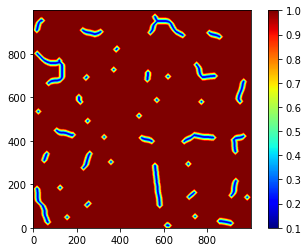

In [105]:
plt.imshow(image_pp,cmap=plt.cm.jet,origin="lower")
plt.colorbar()
plt.show()

In [44]:
np.sum(image_p-image_pp)

0.0

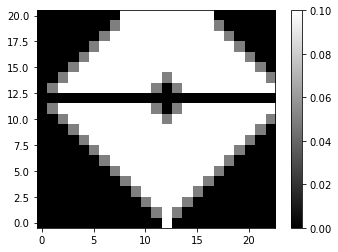

In [45]:
grads=np.gradient(image_p)

plt.imshow(np.abs(grads[0]),cmap=plt.cm.gray,origin="lower")
plt.colorbar()

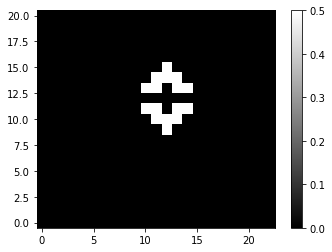

In [46]:
grads=np.gradient(image)

plt.imshow(np.abs(grads[0]),cmap=plt.cm.gray,origin="lower")
plt.colorbar()